In [1]:
# Import essential libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import itertools
import keras
import seaborn as sns
from glob import glob
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers.normalization import BatchNormalization
import os
import cv2
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras import regularizers
from keras.callbacks import Callback
from keras import backend
from keras.models import load_model

In [2]:
blood_cell_directory = os.path.join('..', 'input/lymphoblastsedit/')

# creating a directory for all images present with us and bringing them under same directory
image_directory = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(blood_cell_directory, '*', '*.jpg'))}

In [3]:
NotHealthyPaths = []
for dirname, _, filenames in os.walk(os.path.join(blood_cell_directory, 'Kernels 4/guass One')):
    for filename in filenames:
        if (filename[-3:] == 'jpg'):
            NotHealthyPaths.append(os.path.join(dirname, filename))
NotHealthyPaths

['../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gauss35.jpg',
 '../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gauss6.jpg',
 '../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gauss44.jpg',
 '../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gauss26.jpg',
 '../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gauss29.jpg',
 '../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gauss48.jpg',
 '../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gauss11.jpg',
 '../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gauss8.jpg',
 '../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gauss12.jpg',
 '../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gauss38.jpg',
 '../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gauss14.jpg',
 '../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gauss7.jpg',
 '../input/lymphoblastsedit/Kernels 4/guass One/image_Class_One_gau

In [4]:
HealthyPaths = []
for dirname, _, filenames in os.walk(os.path.join(blood_cell_directory, 'Kernels 4/guass Two')):
    for filename in filenames:
        if (filename[-3:] == 'jpg'):
            HealthyPaths.append(os.path.join(dirname, filename))

In [5]:
df = pd.DataFrame(columns = ['path', 'label'])

In [6]:
# labels for Healthy:0, NotHealthy:1

for index1 in HealthyPaths:
    df=df.append({'path' : str(index1) , 'label' : 0} , ignore_index=True)
for index2 in NotHealthyPaths:
    df=df.append({'path' : str(index2) , 'label' : 1} , ignore_index=True)

In [7]:
df.tail()

,path,label
103,../input/lymphoblastsedit/Kernels 4/guass One/...,1
104,../input/lymphoblastsedit/Kernels 4/guass One/...,1
105,../input/lymphoblastsedit/Kernels 4/guass One/...,1
106,../input/lymphoblastsedit/Kernels 4/guass One/...,1
107,../input/lymphoblastsedit/Kernels 4/guass One/...,1


In [8]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = r
    
    return gray

In [9]:
# Resizing images to 224 x 224
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [10]:
for index in range(len(df['image'])):
    img = Image.fromarray(df['image'][index])
    if img.mode == 'RGB':
        df['image'][index] = rgb2gray(df['image'][index])

In [11]:
import cv2

for i in range(len(df['image'])):
    gray = df['image'][i]
    df['image'][i] = cv2.merge([gray,gray,gray])

In [12]:
df.head()

,path,label,image
0,../input/lymphoblastsedit/Kernels 4/guass Two/...,0,"[[[49, 49, 49], [32, 32, 32], [27, 27, 27], [2..."
1,../input/lymphoblastsedit/Kernels 4/guass Two/...,0,"[[[2, 2, 2], [9, 9, 9], [1, 1, 1], [1, 1, 1], ..."
2,../input/lymphoblastsedit/Kernels 4/guass Two/...,0,"[[[71, 71, 71], [6, 6, 6], [29, 29, 29], [27, ..."
3,../input/lymphoblastsedit/Kernels 4/guass Two/...,0,"[[[0, 0, 0], [0, 0, 0], [28, 28, 28], [34, 34,..."
4,../input/lymphoblastsedit/Kernels 4/guass Two/...,0,"[[[7, 7, 7], [7, 7, 7], [8, 8, 8], [0, 0, 0], ..."


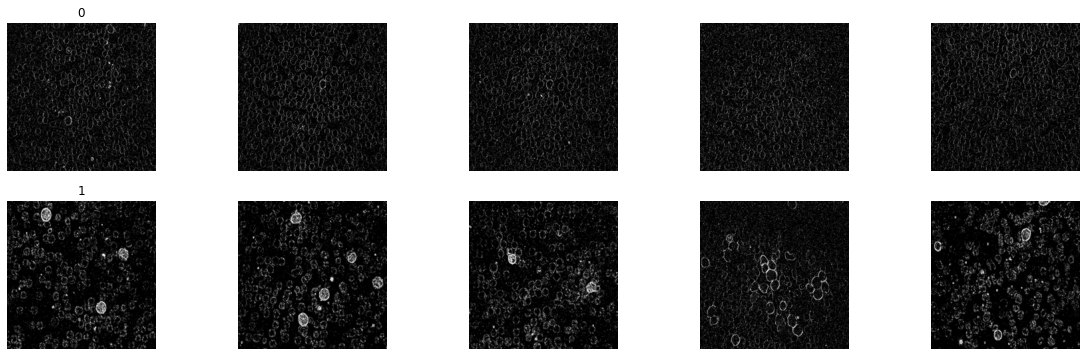

In [13]:
# Printing Sample images for each lesion type
n_samples = 5
num_classes = 2
fig, m_axs = plt.subplots(num_classes, n_samples, figsize = (4*n_samples, 3*num_classes))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['label']).groupby('label')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [14]:
train_df, test_df = train_test_split(df, test_size=0.2)

In [15]:
df['image'].map(lambda x: x.shape).value_counts()


(224, 224, 3)    108
Name: image, dtype: int64

In [16]:
# Print no. of instances of each class present to balace the data
df['label'].value_counts()

0    59
1    49
Name: label, dtype: int64

In [17]:
# Copy fewer class to balance the number of 2 classes
data_aug_rate = [4, 5] # These values are calculated to balance the data
for i in range(num_classes):
    if data_aug_rate[i]:
        train_df=train_df.append([train_df.loc[train_df['label'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
train_df['label'].value_counts()

1    195
0    188
Name: label, dtype: int64

In [18]:
# Copy fewer class to balance the number of 2 classes
data_aug_rate = [4, 4] # These values are calculated to balance the data
for i in range(num_classes):
    if data_aug_rate[i]:
        train_df=train_df.append([train_df.loc[train_df['label'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
train_df['label'].value_counts()

1    780
0    752
Name: label, dtype: int64

In [19]:
features=df.drop(columns=['label'],axis=1)
target=df['label']

In [20]:
x_train = np.asarray(train_df['image'].tolist())
x_test = np.asarray(test_df['image'].tolist())

In [21]:
# Normalizing the data
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [22]:
y_train = to_categorical(train_df['label'], num_classes = num_classes)
y_test = to_categorical(test_df['label'], num_classes = num_classes)

In [23]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.20, random_state = 3)

In [24]:
x_train.shape

(1225, 224, 224, 3)

In [25]:
x_train_flat = x_train.reshape(-1,150528)

In [26]:
df_cifar = pd.DataFrame(x_train_flat)

In [27]:
df_cifar['label'] = df['label']
print('Size of the dataframe: {}'.format(df_cifar.shape))

Size of the dataframe: (1225, 150529)


In [28]:
from sklearn.decomposition import PCA
pca = PCA(1000)
lower_dimension_data = pca.fit_transform(df_cifar.iloc[:,:-1])
lower_dimension_data.shape

(1225, 1000)

In [29]:
#Project lower dimension data onto original features
approximation = pca.inverse_transform(lower_dimension_data)
print(approximation.shape)
approximation = approximation.reshape(-1,224,224, 3)
X_norm = x_train_flat
X_norm = X_norm.reshape(-1,224,224, 3)

(1225, 150528)


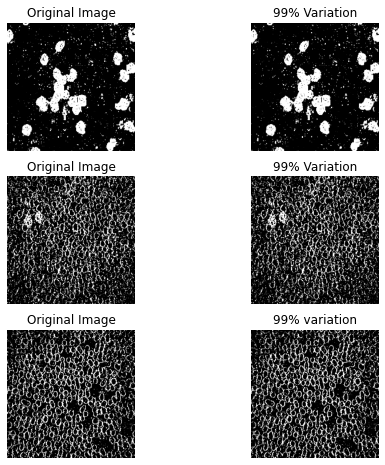

In [30]:
fig4, axarr = plt.subplots(3,2,figsize=(8,8))
axarr[0,0].imshow(X_norm[0,],cmap='gray')
axarr[0,0].set_title('Original Image')
axarr[0,0].axis('off')
axarr[0,1].imshow(approximation[0,],cmap='gray')
axarr[0,1].set_title('99% Variation')
axarr[0,1].axis('off')
axarr[1,0].imshow(X_norm[1,],cmap='gray')
axarr[1,0].set_title('Original Image')
axarr[1,0].axis('off')
axarr[1,1].imshow(approximation[1,],cmap='gray')
axarr[1,1].set_title('99% Variation')
axarr[1,1].axis('off')
axarr[2,0].imshow(X_norm[2,],cmap='gray')
axarr[2,0].set_title('Original Image')
axarr[2,0].axis('off')
axarr[2,1].imshow(approximation[2,],cmap='gray')
axarr[2,1].set_title('99% variation')
axarr[2,1].axis('off')
plt.show()

In [31]:
x2_train = approximation

In [32]:
approximation = 0
X_norm = 0
lower_dimention_data = 0
x_train_flat = 0
df_cifar = 0
df = 0
HealthyPaths = []
NotHealthyPaths = []

In [33]:
#With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x2_train)

In [34]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [35]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [36]:
def ResNet(input_shape = (64, 64, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 64], stage=2, block='b')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [64, 64, 128], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='b')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [37]:
model = ResNet(input_shape = (224, 224, 3), classes = 2)

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [40]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.000001)
x2_train.shape

(1225, 224, 224, 3)

In [41]:
from sklearn.model_selection import KFold
num_folds = 4
# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []
model_history = []
kfold = KFold(n_splits=num_folds, shuffle=True)

In [42]:
# Merge inputs and targets
inputs = np.concatenate((x2_train, x_validate), axis=0)
targets = np.concatenate((y_train, y_validate), axis=0)

In [43]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    
    model = None
    model = ResNet(input_shape = (224, 224, 3), classes = 2)
  # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=32,
              epochs=10,
              verbose=1,
              callbacks=[learning_rate_reduction]
        )
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    model_history.append(history)
    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
36/36 [==============================] - 1s 40ms/step - loss: 0.8325 - accuracy: 0.9138
Epoch 2/10
36/36 [==============================] - 1s 36ms/step - loss: 0.0026 - accuracy: 0.9991
Epoch 3/10
36/36 [==============================] - 1s 35ms/step - loss: 1.8843e-04 - accuracy: 1.0000
Epoch 4/10
36/36 [==============================] - 1s 37ms/step - loss: 9.4411e-05 - accuracy: 1.0000
Epoch 5/10
36/36 [==============================] - 1s 35ms/step - loss: 3.6116e-05 - accuracy: 1.0000
Epoch 6/10
36/36 [==============================] - 1s 36ms/step - loss: 3.1940e-05 - accuracy: 1.0000
Epoch 7/10
36/36 [==============================] - 1s 36ms/step - loss: 1.5695e-05 - accuracy: 1.0000
Epoch 8/10
36/36 [==============================] - 1s 36ms/step - loss: 3.0641e-05 - accuracy: 1.0000
Epoch 9/10
36/36 [==============================] - 1s 35ms/step - loss: 2.5809e-05 - a

In [44]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.002189534017816186 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 2 - Loss: 8.520230767317116e-05 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.00021977168216835707 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 4 - Loss: 3.0116993002593517e-05 - Accuracy: 100.0%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 100.0 (+- 0.0)
> Loss: 0.0006311562501650769
------------------------------------------------------------------------


In [45]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

1/1 [==============================] - 0s 2ms/step - loss: 0.0755 - accuracy: 0.9545
Loss of the model is -  0.07548978924751282
1/1 [==============================] - 0s 2ms/step - loss: 0.0755 - accuracy: 0.9545
Accuracy of the model is -  95.45454382896423 %


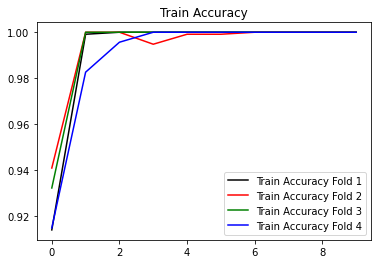

In [46]:
plt.title('Train Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.legend()
plt.show()

In [47]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.argmax(y_test, axis = 1), np.argmax(y_pred_keras, axis = 1))

In [48]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [49]:
auc_keras

0.95

In [50]:
import scipy.stats
from scipy import stats


def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


alpha = .95
y_pred = np.argmax(y_pred_keras, axis = 1)
y_true = np.argmax(y_test, axis=1)

auc, auc_cov = delong_roc_variance(y_true, y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

AUC: 0.95
AUC COV: 0.0024999999999999996
95% AUC CI: [0.8520018 1.       ]


In [51]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [52]:
from sklearn.metrics import classification_report
test_pred = model.predict(x_test)
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(test_pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.90      0.95        10

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22



In [53]:
test_cm = confusion_matrix(np.argmax(y_test, axis = 1),np.argmax(test_pred, axis = 1))

In [54]:
confusion_metrics(test_cm)

True Positives: 9
True Negatives: 12
False Positives: 0
False Negatives: 1
--------------------------------------------------
Accuracy: 0.95
Mis-Classification: 0.05
Sensitivity: 0.9
Specificity: 1.0
Precision: 1.0
f_1 Score: 0.95


In [55]:
predict = []
cmKfold = []
for train, test in kfold.split(inputs, targets):
    pred = model.predict(inputs[test])
    predict.append(pred)
    cmkfold = confusion_matrix(np.argmax(targets[test], axis = 1),np.argmax(pred, axis = 1))
    cmKfold.append(cmkfold)

In [56]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [57]:
pred = model.predict(x_validate)
print(classification_report(np.argmax(y_validate, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       159

    accuracy                           1.00       307
   macro avg       1.00      1.00      1.00       307
weighted avg       1.00      1.00      1.00       307



In [58]:
cm = confusion_matrix(np.argmax(y_validate, axis = 1),np.argmax(pred, axis = 1))
cm

array([[148,   0],
       [  0, 159]])

In [59]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

In [60]:
print(cmKfold[0])
print(cmKfold[1])
print(cmKfold[2])
print(cmKfold[3])

[[187   0]
 [  0 196]]
[[201   0]
 [  0 182]]
[[182   0]
 [  0 201]]
[[182   0]
 [  0 201]]


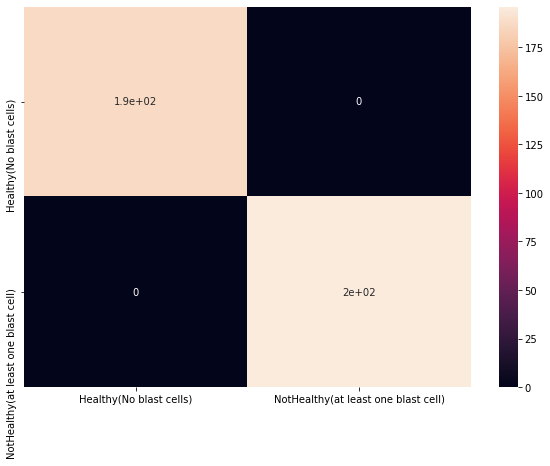

In [62]:
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
array =[[187,   0],
       [  0, 196]]
df_cm = pd.DataFrame(array, index = [i for i in ["Healthy(No blast cells)", "NotHealthy(at least one blast cell)"]],
                  columns = [i for i in ["Healthy(No blast cells)", "NotHealthy(at least one blast cell)"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

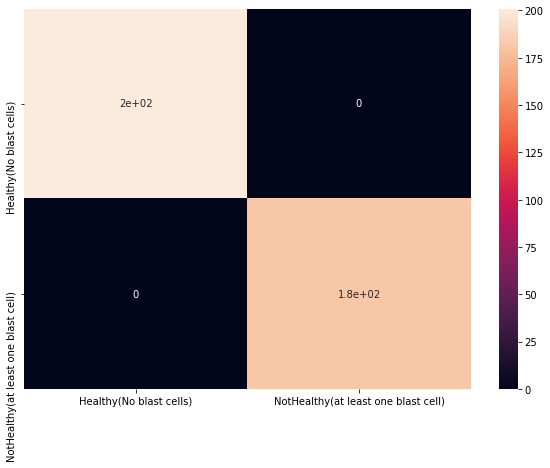

In [63]:
array =[[201, 0],
         [0, 182]]
df_cm = pd.DataFrame(array, index = [i for i in ["Healthy(No blast cells)", "NotHealthy(at least one blast cell)"]],
                  columns = [i for i in ["Healthy(No blast cells)", "NotHealthy(at least one blast cell)"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

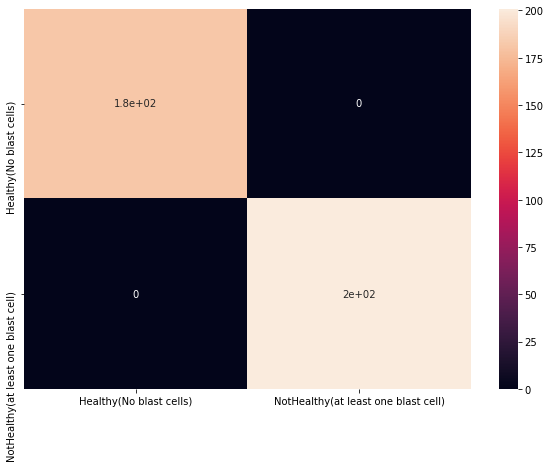

In [64]:
array =[[182, 0],
         [0, 201]]
df_cm = pd.DataFrame(array, index = [i for i in ["Healthy(No blast cells)", "NotHealthy(at least one blast cell)"]],
                  columns = [i for i in ["Healthy(No blast cells)", "NotHealthy(at least one blast cell)"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

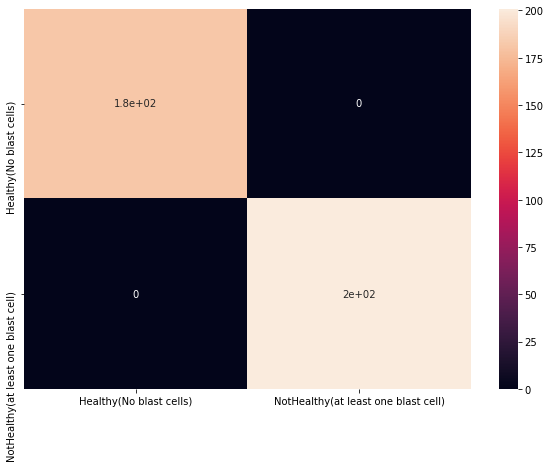

In [65]:
array =[[182, 0],
         [0, 201]]
df_cm = pd.DataFrame(array, index = [i for i in ["Healthy(No blast cells)", "NotHealthy(at least one blast cell)"]],
                  columns = [i for i in ["Healthy(No blast cells)", "NotHealthy(at least one blast cell)"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

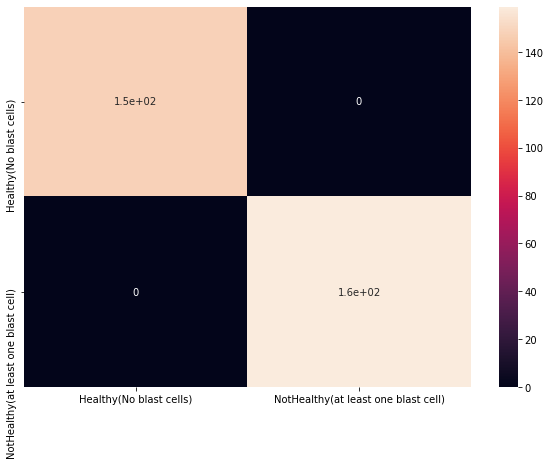

In [66]:
array =[[148, 0],
         [0, 159]]
df_cm = pd.DataFrame(array, index = [i for i in ["Healthy(No blast cells)", "NotHealthy(at least one blast cell)"]],
                  columns = [i for i in ["Healthy(No blast cells)", "NotHealthy(at least one blast cell)"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)